In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
from torch.autograd import Variable
import torch.nn.functional as F
import pickle
from cnn_finetune import make_model

In [2]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

labelencoder_dic = {0: 'ant_man', 1: 'aqua_man', 2: 'avengers', 3: 'bat_man', 4: 'black_panther', 5: 'captain_america', 
                    6: 'cat_woman', 7: 'ghostrider', 8: 'hulk', 9: 'iron_man', 10: 'spider_man', 11: 'super_man'}

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = 160

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

torch.random.manual_seed(10);
torch.cuda.manual_seed(10)

In [3]:
#Dataset for PyTorch
class SuperheroesDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)           
        label = self.y[idx]
        out = (img, label)
        return out

#Train model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    
        
def predict(test_loader, model):
    model.eval()       #Sets the module in evaluation mode
    predictions = []
    
    for i, data in enumerate(tqdm(test_loader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        predictions.append(preds[0])
        
    return predictions

In [9]:
transform_data = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.CenterCrop(IMG_SIZE),transforms.ToTensor()])

transform_train = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])
transform_test = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

use_gpu = torch.cuda.is_available()

labelencoder = LabelEncoder()

x_train_df = train_df['img_path'].values
y_train_df = train_df['superhero'].values
y_train_df = labelencoder.fit_transform(y_train_df)
x_test_df = test_df['img_path'].values

x_train, x_valid, y_train, y_valid = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=y_train_df)
x_test = x_test_df
y_test = np.zeros_like(x_test)

batch_size = 64
train_set = SuperheroesDataset(x_train, y_train, transform_train)
train_load = DataLoader(train_set,batch_size=batch_size, pin_memory=True)
valid_set = SuperheroesDataset(x_valid, y_valid, transform_test)
valid_load = DataLoader(valid_set,batch_size=batch_size, pin_memory=True)
test_set = SuperheroesDataset(x_test, y_test, transform_test)
test_load = DataLoader(test_set,batch_size=1, pin_memory=True)

image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

criterion = nn.CrossEntropyLoss()

In [5]:
#Train model
def train_model_batch(model, criterion, optimizer, scheduler=None, num_epochs=2, batch_accum=1):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            loss_mini_batch = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):

                inputs, labels = data

                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)                

                if phase == 'train':
                    loss.backward()

                running_loss += loss.data[0]*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


                if (i+1) % batch_accum == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

In [6]:
model_ft = make_model('resnet34', num_classes=12, pretrained=True)
model_ft.cuda();

In [ ]:
# resnet34, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs34, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2, batch_accum=1)

Epoch 0/1
----------


Epoch 0/1
----------
train Loss: 2.3169 Acc: 0.2317
val Loss: 4.5346 Acc: 0.1481
lr:  0.001

Epoch 1/1
----------
train Loss: 2.0097 Acc: 0.3076
val Loss: 2.4191 Acc: 0.2879
lr:  0.001

Training complete in 0m 49s
Best val Acc: 0.287948, epoch 1


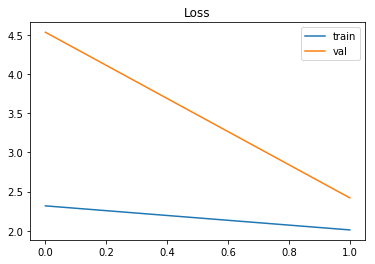

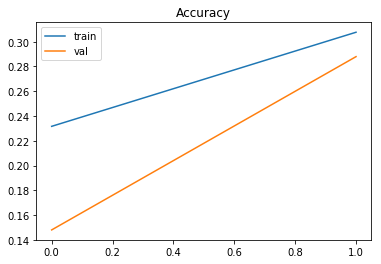

In [7]:
# resnet34, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs34, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2, batch_accum=2)

Epoch 0/29
----------
train Loss: 2.2355 Acc: 0.2324
val Loss: 8.6625 Acc: 0.1435
lr:  0.001

Epoch 1/29
----------
train Loss: 2.0261 Acc: 0.3125
val Loss: 2.8477 Acc: 0.2420
lr:  0.001

Epoch 2/29
----------
train Loss: 1.8707 Acc: 0.3656
val Loss: 2.1141 Acc: 0.3450
lr:  0.001

Epoch 3/29
----------
train Loss: 1.7623 Acc: 0.4160
val Loss: 1.8503 Acc: 0.4112
lr:  0.001

Epoch 4/29
----------
train Loss: 1.6920 Acc: 0.4305
val Loss: 2.1154 Acc: 0.2852
lr:  0.001

Epoch 5/29
----------
train Loss: 1.6052 Acc: 0.4692
val Loss: 2.1064 Acc: 0.3753
lr:  0.001

Epoch 6/29
----------
train Loss: 1.5428 Acc: 0.4869
val Loss: 1.9750 Acc: 0.3891
lr:  0.001

Epoch 7/29
----------
train Loss: 1.5351 Acc: 0.4979
val Loss: 1.8813 Acc: 0.4305
lr:  0.001

Epoch 8/29
----------
train Loss: 1.4686 Acc: 0.5179
val Loss: 1.9899 Acc: 0.3661
lr:  0.001

Epoch 9/29
----------
train Loss: 1.4571 Acc: 0.5170
val Loss: 2.1925 Acc: 0.3588
lr:  0.001

Epoch 10/29
----------
train Loss: 1.3757 Acc: 0.5460
val Lo

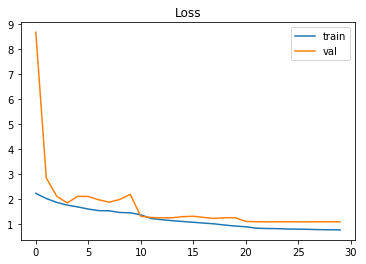

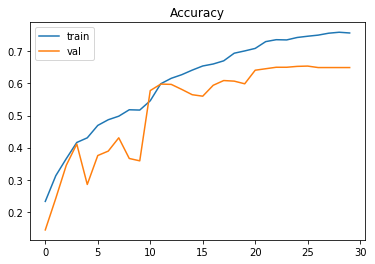

In [11]:
# resnet34, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs34, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=2)

Epoch 0/59
----------
train Loss: 2.2867 Acc: 0.2278
val Loss: 2.9557 Acc: 0.1785
lr:  0.001

Epoch 1/59
----------
train Loss: 1.9770 Acc: 0.3438
val Loss: 2.2659 Acc: 0.3349
lr:  0.001

Epoch 2/59
----------
train Loss: 1.8591 Acc: 0.3919
val Loss: 1.8557 Acc: 0.4020
lr:  0.001

Epoch 3/59
----------
train Loss: 1.8199 Acc: 0.3969
val Loss: 2.7624 Acc: 0.2328
lr:  0.001

Epoch 4/59
----------
train Loss: 1.7607 Acc: 0.4222
val Loss: 1.9772 Acc: 0.3404
lr:  0.001

Epoch 5/59
----------
train Loss: 1.7088 Acc: 0.4418
val Loss: 1.9422 Acc: 0.4103
lr:  0.001

Epoch 6/59
----------
train Loss: 1.6508 Acc: 0.4722
val Loss: 1.9115 Acc: 0.4075
lr:  0.001

Epoch 7/59
----------
train Loss: 1.5473 Acc: 0.4910
val Loss: 1.6208 Acc: 0.4701
lr:  0.001

Epoch 8/59
----------
train Loss: 1.5230 Acc: 0.4993
val Loss: 2.0745 Acc: 0.3634
lr:  0.001

Epoch 9/59
----------
train Loss: 1.5837 Acc: 0.4864
val Loss: 3.9677 Acc: 0.2217
lr:  0.001

Epoch 10/59
----------
train Loss: 1.4675 Acc: 0.5163
val Lo

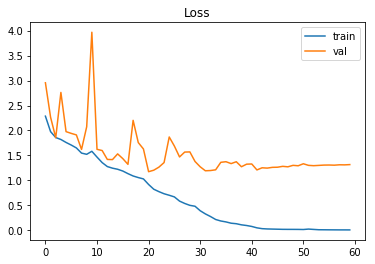

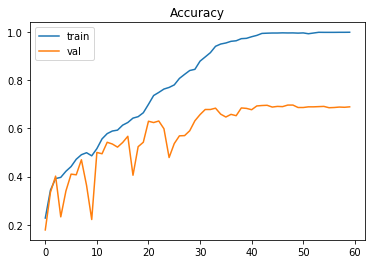

In [12]:
# resnet34, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)
model_ft.apply(reset)
model_rs34, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60, batch_accum=2)

Epoch 0/29
----------
train Loss: 2.1903 Acc: 0.2540
val Loss: 2.4755 Acc: 0.2291
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8807 Acc: 0.3553
val Loss: 2.1090 Acc: 0.3211
lr:  0.001

Epoch 2/29
----------
train Loss: 1.7737 Acc: 0.4024
val Loss: 2.0902 Acc: 0.3303
lr:  0.001

Epoch 3/29
----------
train Loss: 1.6953 Acc: 0.4238
val Loss: 1.9868 Acc: 0.3661
lr:  0.001

Epoch 4/29
----------
train Loss: 1.6262 Acc: 0.4526
val Loss: 1.8320 Acc: 0.3735
lr:  0.001

Epoch 5/29
----------
train Loss: 1.5394 Acc: 0.4841
val Loss: 2.4367 Acc: 0.2962
lr:  0.001

Epoch 6/29
----------
train Loss: 1.4703 Acc: 0.5099
val Loss: 1.6945 Acc: 0.4609
lr:  0.001

Epoch 7/29
----------
train Loss: 1.3912 Acc: 0.5481
val Loss: 1.4659 Acc: 0.5308
lr:  0.001

Epoch 8/29
----------
train Loss: 1.3275 Acc: 0.5552
val Loss: 1.5551 Acc: 0.5060
lr:  0.001

Epoch 9/29
----------
train Loss: 1.2499 Acc: 0.5835
val Loss: 1.7039 Acc: 0.4977
lr:  0.001

Epoch 10/29
----------
train Loss: 1.1009 Acc: 0.6358
val Lo

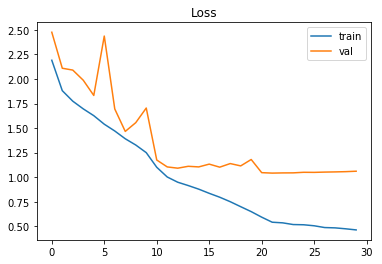

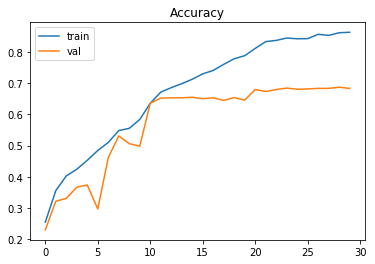

In [7]:
# resnet34, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs34, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/39
----------
train Loss: 2.2017 Acc: 0.2593
val Loss: 3.6474 Acc: 0.1674
lr:  0.001

Epoch 1/39
----------
train Loss: 1.9107 Acc: 0.3730
val Loss: 2.1670 Acc: 0.2925
lr:  0.001

Epoch 2/39
----------
train Loss: 1.7952 Acc: 0.4130
val Loss: 1.8984 Acc: 0.3937
lr:  0.001

Epoch 3/39
----------
train Loss: 1.7114 Acc: 0.4413
val Loss: 1.9162 Acc: 0.3956
lr:  0.001

Epoch 4/39
----------
train Loss: 1.6396 Acc: 0.4664
val Loss: 1.9252 Acc: 0.3937
lr:  0.001

Epoch 5/39
----------
train Loss: 1.5572 Acc: 0.4915
val Loss: 2.3622 Acc: 0.3551
lr:  0.001

Epoch 6/39
----------
train Loss: 1.4971 Acc: 0.5081
val Loss: 2.1985 Acc: 0.3155
lr:  0.001

Epoch 7/39
----------
train Loss: 1.4460 Acc: 0.5265
val Loss: 2.0526 Acc: 0.3901
lr:  0.001

Epoch 8/39
----------
train Loss: 1.3909 Acc: 0.5451
val Loss: 1.7410 Acc: 0.4738
lr:  0.001

Epoch 9/39
----------
train Loss: 1.3087 Acc: 0.5734
val Loss: 1.6946 Acc: 0.5225
lr:  0.001

Epoch 10/39
----------
train Loss: 1.1885 Acc: 0.6144
val Lo

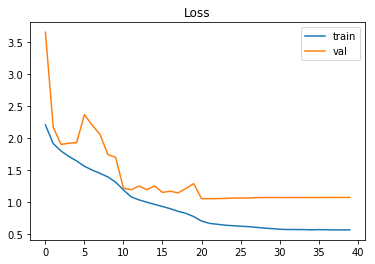

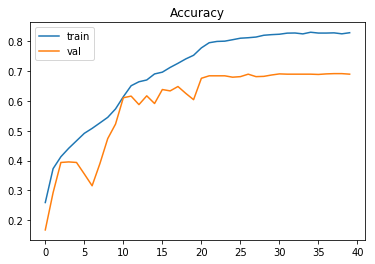

In [10]:
# resnet34, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs34_1, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

In [5]:
model_ft = make_model('resnet34', num_classes=12, pretrained=True, dropout_p=0.5)
model_ft.cuda();

Epoch 0/39
----------
train Loss: 2.2280 Acc: 0.2651
val Loss: 2.1193 Acc: 0.2953
lr:  0.001

Epoch 1/39
----------
train Loss: 1.9405 Acc: 0.3463
val Loss: 1.9762 Acc: 0.3339
lr:  0.001

Epoch 2/39
----------
train Loss: 1.8359 Acc: 0.4020
val Loss: 1.8257 Acc: 0.3983
lr:  0.001

Epoch 3/39
----------
train Loss: 1.7215 Acc: 0.4353
val Loss: 1.7213 Acc: 0.4655
lr:  0.001

Epoch 4/39
----------
train Loss: 1.6290 Acc: 0.4584
val Loss: 1.8734 Acc: 0.3937
lr:  0.001

Epoch 5/39
----------
train Loss: 1.5324 Acc: 0.4988
val Loss: 1.6977 Acc: 0.4305
lr:  0.001

Epoch 6/39
----------
train Loss: 1.5052 Acc: 0.5129
val Loss: 1.9898 Acc: 0.4351
lr:  0.001

Epoch 7/39
----------
train Loss: 1.4110 Acc: 0.5499
val Loss: 1.7319 Acc: 0.4931
lr:  0.001

Epoch 8/39
----------
train Loss: 1.3579 Acc: 0.5605
val Loss: 1.4125 Acc: 0.5428
lr:  0.001

Epoch 9/39
----------
train Loss: 1.2827 Acc: 0.5916
val Loss: 1.4681 Acc: 0.5382
lr:  0.001

Epoch 10/39
----------
train Loss: 1.1313 Acc: 0.6374
val Lo

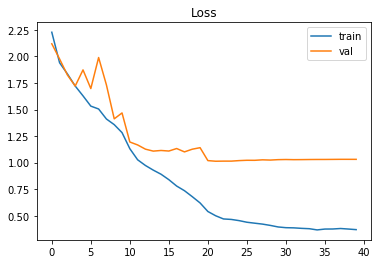

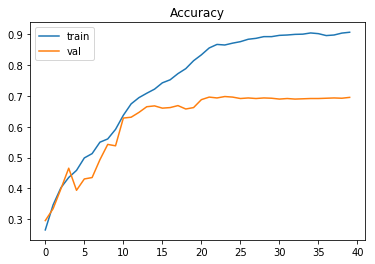

In [6]:
# resnet34, batch_size=128, lr=0.001, pretrained=True, dropout_p=0.5
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs34_1, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

In [7]:
model_ft = make_model('vgg11_bn', num_classes=12, pretrained=True, input_size=(160, 160))
model_ft.cuda();

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to C:\Users\Андрей/.torch\models\vgg11_bn-6002323d.pth
100%|███████████████████████████████████████████████████████████████| 531503671/531503671 [01:20<00:00, 6775716.66it/s]


In [10]:
# vgg11_bn, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg11, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCTensorMath.cu:35

In [16]:
model_ft.apply(reset);

In [13]:
len(dataloaders['train'])

34

In [19]:
dataloaders['train'][0]

TypeError: 'DataLoader' object does not support indexing

In [8]:
for i,data in enumerate(dataloaders['train']):
    if i==0: d = data
    if i==1: d1 = data
    #else: break    

In [11]:
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
model_ft.train(True);
inputs, labels = d
inputs = Variable(inputs.cuda())
labels = Variable(labels.cuda())
optimizer.zero_grad()
outputs = model_ft(inputs)
_, preds = torch.max(outputs.data, 1)
loss = criterion(outputs, labels)
loss

Variable containing:
 2.5852
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [12]:
loss.backward()
optimizer.step()

In [13]:
running_loss = loss.data[0] * inputs.size(0)
running_loss

330.9085693359375

In [15]:
running_corrects = 0
running_corrects += torch.sum(preds == labels.data)
running_corrects

22

In [19]:
epoch_loss = running_loss / dataset_sizes['train']
epoch_loss

0.07614095014632709

In [17]:
epoch_acc = running_corrects / dataset_sizes['train']
epoch_acc

0.0050621260929590425

In [18]:
dataset_sizes['train']

4346

In [7]:
inputs, labels = d1
inputs = Variable(inputs.cuda())
labels = Variable(labels.cuda())
optimizer.zero_grad()
outputs = model_ft(inputs)
_, preds = torch.max(outputs.data, 1)
loss = criterion(outputs, labels)
loss

NameError: name 'd1' is not defined

Variable containing:
 2.4697
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [41]:
loss.backward()

In [44]:
loss

Variable containing:
 2.4697
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [43]:
optimizer.step()

In [48]:
running_loss = loss.data[0] * inputs.size(0)
running_loss

316.1268310546875

In [49]:
dataset_sizes['train']

4346

In [50]:
epoch_loss = running_loss / dataset_sizes['train']
epoch_loss

0.07273972182574494

In [52]:
running_corrects = 0
running_corrects += torch.sum(preds == labels.data)
running_corrects

17

In [53]:
epoch_acc = running_corrects / dataset_sizes['train']
epoch_acc

0.003911642890013806